# Deep Learning in Active Magnetic Regenerators

This Notebook presents the results for the application of Neural Networks in the prediction of the Cooling Capacity ($\dot{Q}_\mathrm{C}$ or $Qc$) and the Magnetization Power ($\dot{W}_\mathrm{m}$ or $Wm$) of Active Magnetic Regenerators. The Dataset consists in 532 points coming from numerical simulations.

### Importing the Modules

In [14]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import joblib

mpl.style.use('default')
plt.rc('text',usetex = True)
plt.rc('font', family='serif',size = 12)

### Plotting Functions 

In [2]:
def plot_results(y_train,y_pred_train,y_test,y_pred_test,Obj):
    
    plt.figure()
    plt.plot(y_train,y_pred_train,'o',color = '#1f77b4', mfc='none', label = 'Training Set')
    plt.plot(y_test,y_pred_test,'x' ,color = '#2ca02c', mfc='none',label = 'Test Set',)
    
    if Obj == 'Qc':
        Aux = np.linspace(10,300)
        plt.plot(Aux,0.9*Aux,'k--')
        plt.plot(Aux,1.1*Aux,'k--')
        plt.text(140, 180, '$+ 10 \%$', fontsize=12)
        plt.text(150, 120, '$- 10 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{Q}_\mathrm{C}$ [W] - NN' )
        plt.xlabel(r' $\dot{Q}_\mathrm{C}$ [W] - Target')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Qc/Qc - NN.png', format = 'png', bbox_inches='tight') 
    
    elif Obj == 'Wm':
        Aux = np.linspace(10,60)
        plt.plot(Aux,0.9*Aux,'k--')
        plt.plot(Aux,1.1*Aux,'k--')
        plt.text(23, 17, '$- 10 \%$', fontsize=12)
        plt.text(19, 28, '$+ 10 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{W}_\mathrm{AMR,Mag}$ [W] - NN' )
        plt.xlabel(r' $\dot{W}_\mathrm{AMR,Mag}$ [W] - Target')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Wm/Wm - NN.png', format = 'png', bbox_inches='tight') 

### Reading the Input Parameteres 

The independent variable are the Width ($H$), Height ($H$) and Length ($L$) of the porous medium, the frequency ($f$) and mass flow rate ($mf$) of the Active Magnetic Regenerator, the Inlet Temperatures at the Hot ($Th$) and Cold ($Tc$) ends and the Applied Magnetic Field ($B$).

The dependent variables are the Cooling Capacity ($Qc$) and Magnetization Power ($Wm$).

In [3]:
Inputs = pd.read_excel('Data/Data_AMR.xlsx',index_col = 0, dtype=np.float32) # Input Data
X = Inputs[['W','H','f','mf','B','L','Th','Tc']]
y = Inputs[['Qc','Wm']]

### Train-Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)  

### Scaling the Features

In [5]:
sc = StandardScaler()
x_train = sc.fit_transform(X_train)
x_test = sc.transform(X_test)

### Building the Model

In [6]:
def Build(hp):
    
    #Grouping a stack of Layers in Model
    model = tf.keras.Sequential()
    
    # Adding the Layers
    # The number of layers, neurons in each one and activation functions are going to be tunned 
    for i in range(hp.Int('layers', 0, 5)):
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), 10, 10100, step=100),
                                        activation=hp.Choice('act_' + str(i), ['relu','sigmoid','selu'])))
        
        #Applying a Batch Normalization Layer after Dense Layer
        model.add(BatchNormalization())
        
    # Adding a final Layer 
    model.add(tf.keras.layers.Dense(1, activation='selu'))
    
    # Compiling the Model with the Adam optimization algorithm
    model.compile(optimizer=Adam(),
                  loss="mean_squared_error", 
                  metrics=['accuracy'])
    return model

### Batch Optimization

Overriding run_trial in MyTuner (https://kegui.medium.com/how-to-tune-the-number-of-epochs-and-batch-size-in-keras-tuner-c2ab2d40878d)

In [7]:
class MyTuner(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 20, 200, step=10)
        super(MyTuner, self).run_trial(trial, *args, **kwargs)

### Defining the Tuner

In [49]:
def NeuNet(X_train,y_train,max_epochs,Obj):
    
    # Defining the Tuner
    tuner = MyTuner(Build,
                    objective = 'val_loss',
                    max_epochs = max_epochs,
                    directory='KT_Dir',
                    project_name='KT_Hyperband_' + Obj,
                    executions_per_trial = 1,   
    )
    
    # Hyperparameter Optimization
    tuner.search(X_train,
                 y_train[Obj],
                 epochs=max_epochs,
                 callbacks=[EarlyStopping('val_loss', patience=3)],
                 verbose=1,
                 validation_split=0.2)
    
  
    # Trainning the Best Model
    best_model = tuner.get_best_models()[0]
    best_model.build(x_train.shape)
    best_model.fit(x_train,
                   y_train[Obj], 
                   epochs=max_epochs,
                   batch_size=tuner.get_best_hyperparameters(num_trials=1)[0].get('batch_size')
    )
    
    # Saving the Model
    best_model.save('Models/'+Obj+'/'+ Obj +'_NN.h5')
    
     #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], best_model.predict(X_train))))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], best_model.predict(X_test)))) 

    # Plotting the Results
    plot_results(y_train[Obj], best_model.predict(X_train), y_test[Obj], best_model.predict(X_test), Obj) 

INFO:tensorflow:Reloading Oracle from existing project KT_Dir\KT_Hyperband_Wm\oracle.json
INFO:tensorflow:Reloading Tuner from KT_Dir\KT_Hyperband_Wm\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/20
11/11 [==============================] - 0s 3ms/step - loss: 381.9783 - accuracy: 0.0000e+00
Epoch 2/20
11/11 [==============================] - 0s 3ms/step - loss: 167.9091 - accuracy: 0.0000e+00
Epoch 3/20
11/11 [==============================] - 0s 3ms/step - loss: 105.7352 - accuracy: 0.0000e+00
Epoch 4/20
11/11 [==============================] - 0s 2ms/step - loss: 62.8774 - accuracy: 0.0000e+00
Epoch 5/20
11/11 [==============================] - 0s 2ms/step - loss: 29.2331 - accuracy: 0.0000e+00
Epoch 6/20
11/11 [==============================] - 0s 2ms/step - loss: 20.3858 - accuracy: 0.0000e+00
Epoch 7/20
11/11 [==============================] - 0s 2ms/step - loss: 14.6517 - accuracy: 0.0000e+00
Epoch 8/20
11/11 [==============================] - 0s 2ms/step - loss: 12.0

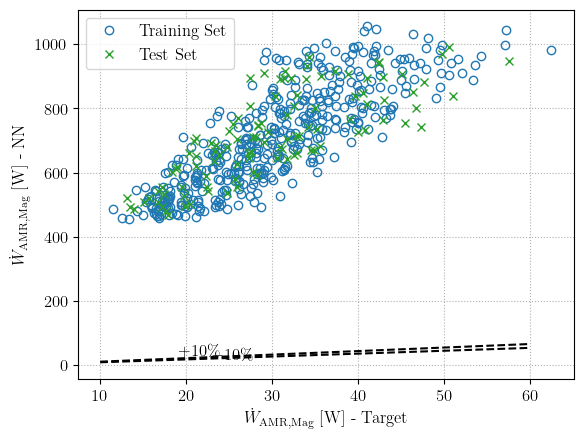

In [50]:
NeuNet(X_train,y_train,20,'Wm')